In [13]:
# Necessary imports

import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS


from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

# Set seed for random generators
algorithm_globals.random_seed = 42

In [14]:
# declare quantum instance
qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))

In [15]:
# Additional torch-related imports
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F

In [16]:
# Train Dataset
# -------------

# Set train shuffle seed (for reproducibility)
manual_seed(42)

batch_size = 1
n_samples = 100  # We will concentrate on the first 100 samples

# Use pre-defined torchvision function to load MNIST train data
X_train = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_train.targets == 0)[0][:n_samples], np.where(X_train.targets == 1)[0][:n_samples]
)
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# Define torch dataloader with filtered data
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

In [17]:
# Define and create QNN
def create_qnn():
    feature_map = ZZFeatureMap(2)
    ansatz = RealAmplitudes(2, reps=1)
    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = TwoLayerQNN(
        2,
        feature_map,
        ansatz,
        input_gradients=True,
        exp_val=AerPauliExpectation(),
        quantum_instance=qi,
    )
    return qnn


qnn4 = create_qnn()
print(qnn4.operator)

ComposedOp([
  OperatorMeasurement(1.0 * ZZ),
  CircuitStateFn(
       ┌──────────────────────────┐┌──────────────────────────────────────┐
  q_0: ┤0                         ├┤0                                     ├
       │  ZZFeatureMap(x[0],x[1]) ││  RealAmplitudes(θ[0],θ[1],θ[2],θ[3]) │
  q_1: ┤1                         ├┤1                                     ├
       └──────────────────────────┘└──────────────────────────────────────┘
  )
])


In [18]:
# Define torch NN module


class Net(Module):
    def __init__(self, qnn):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, 2)  # 2-dimensional input to QNN
        self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        # uniformly at random from interval [-1,1].
        self.fc3 = Linear(1, 1)  # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        return cat((x, 1 - x), -1)


model4 = Net(qnn4)

In [20]:
# Define model, optimizer, and loss function
optimizer = optim.Adam(model4.parameters(), lr=0.001)
loss_func = NLLLoss()

# Start training
epochs = 10  # Set number of epochs
loss_list = []  # Store loss history
model4.train()  # Set model to training mode

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model4(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

Training [10%]	Loss: -0.6930
Training [20%]	Loss: -0.8839
Training [30%]	Loss: -1.1309
Training [40%]	Loss: -1.3714
Training [50%]	Loss: -1.6113
Training [60%]	Loss: -1.8221
Training [70%]	Loss: -2.0227
Training [80%]	Loss: -2.2711
Training [90%]	Loss: -2.4704
Training [100%]	Loss: -2.6858


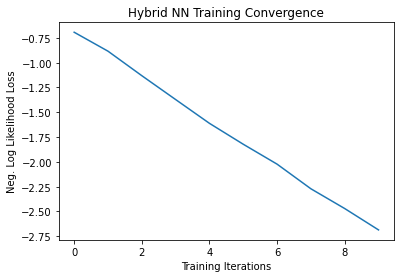

In [21]:

# Plot loss convergence
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Neg. Log Likelihood Loss")
plt.show()